In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix,classification_report,f1_score  
import cv2
import os
import torch
import seaborn as sns
from sklearn.model_selection import train_test_split
from datasets import load_dataset,load_metric,concatenate_datasets
from huggingface_hub import notebook_login
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer, pipeline
from torchvision.transforms import (  # Import image transformation functions
    CenterCrop,  # Center crop an image
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to images
    RandomResizedCrop,  # Crop and resize images randomly
    RandomHorizontalFlip,  # Apply random horizontal flip
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize images
    ToTensor  # Convert images to PyTorch tensors
)
import itertools  # Import 'itertools' for iterators and looping
from transformers import TrainingArguments
from accelerate import Accelerator

2024-08-12 23:04:38.398037: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 23:04:38.398158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 23:04:38.666227: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
model_checkpoint = "google/vit-base-patch16-224"

In [5]:
from datasets import load_metric

metric = load_metric("accuracy")

/tmp/ipykernel_34/1780215247.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


In [6]:
from datasets import load_dataset

fer_dataset = load_dataset("imagefolder", data_dir="/kaggle/input/fer2013")


Resolving data files:   0%|          | 0/28709 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/7178 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [7]:
fer_dataset


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 28709
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 7178
    })
})

In [8]:
from datasets import DatasetDict, ClassLabel

dataset = DatasetDict()


In [9]:
dataset['train'] = fer_dataset


In [10]:
dataset


DatasetDict({
    train: DatasetDict({
        train: Dataset({
            features: ['image', 'label'],
            num_rows: 28709
        })
        test: Dataset({
            features: ['image', 'label'],
            num_rows: 7178
        })
    })
})

In [11]:
# To access the first item in the 'train' split of the inner DatasetDict
first_train_item = dataset['train']['train'][0]

# To access the first item in the 'test' split of the inner DatasetDict
first_test_item = dataset['train']['test'][0]

In [12]:
dataset['train']['train'].features


{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], id=None)}

In [13]:
labels = dataset["train"]['train'].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [14]:
label2id


{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [15]:
image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [16]:
image_mean, image_std = image_processor.image_mean, image_processor.image_std
size = image_processor.size["height"]
print("Size: ", size)

normalize = Normalize(mean=image_mean, std=image_std)

train_tf = Compose([
    Resize((size, size)),
    RandomRotation(90),
    RandomAdjustSharpness(2),
    RandomHorizontalFlip(0.5),
    ToTensor(),
    normalize
])

val_tf = Compose([
    Resize((size, size)),
    ToTensor(),
    normalize
])

Size:  224


In [17]:
def train_transforms(examples):
    examples['pixel_values'] = [train_tf(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [val_tf(image.convert("RGB")) for image in examples['image']]
    return examples

In [18]:
train_data = dataset["train"]["train"]
val_data = dataset["train"]["test"]

# If you want to further split the train data:
splits = train_data.train_test_split(test_size=0.2)
train_data = splits['train']
additional_val_data = splits['test']

# Apply transformations
train_data = train_data.map(train_transforms, batched=True)
val_data = val_data.map(val_transforms, batched=True)

# Set the format of the datasets
train_data.set_format('torch', columns=['pixel_values', 'label'])
val_data.set_format('torch', columns=['pixel_values', 'label'])

Map:   0%|          | 0/22967 [00:00<?, ? examples/s]

Map:   0%|          | 0/7178 [00:00<?, ? examples/s]

In [19]:
train_data

Dataset({
    features: ['image', 'label', 'pixel_values'],
    num_rows: 22967
})

In [20]:
val_data


Dataset({
    features: ['image', 'label', 'pixel_values'],
    num_rows: 7178
})

In [21]:
train_data.set_transform(train_transforms)
val_data.set_transform(val_transforms)

In [22]:
train_data[0]


{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=48x48>,
 'label': 2,
 'pixel_values': tensor([[[-1.0000, -1.0000, -1.0000,  ...,  0.2941, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ...,  0.6235, -1.0000, -1.0000],
          [-0.8510, -0.7804, -0.7490,  ...,  0.6471, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -0.7176,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -0.6706,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -0.6941,  ..., -1.0000, -1.0000, -1.0000]],
 
         [[-1.0000, -1.0000, -1.0000,  ...,  0.2941, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ...,  0.6235, -1.0000, -1.0000],
          [-0.8510, -0.7804, -0.7490,  ...,  0.6471, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -0.7176,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -0.6706,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -0.6941,  ..., -1.0000, -1.0000, -1.0000]],
 


In [23]:
val_data[0]


{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=48x48>,
 'label': 0,
 'pixel_values': tensor([[[-0.6392, -0.6392, -0.6392,  ..., -0.8275, -0.8275, -0.8275],
          [-0.6392, -0.6392, -0.6392,  ..., -0.8275, -0.8275, -0.8275],
          [-0.6392, -0.6392, -0.6392,  ..., -0.8275, -0.8275, -0.8275],
          ...,
          [ 0.6314,  0.6314,  0.6314,  ...,  0.4902,  0.4902,  0.4902],
          [ 0.6314,  0.6314,  0.6314,  ...,  0.4824,  0.4824,  0.4824],
          [ 0.6314,  0.6314,  0.6314,  ...,  0.4824,  0.4824,  0.4824]],
 
         [[-0.6392, -0.6392, -0.6392,  ..., -0.8275, -0.8275, -0.8275],
          [-0.6392, -0.6392, -0.6392,  ..., -0.8275, -0.8275, -0.8275],
          [-0.6392, -0.6392, -0.6392,  ..., -0.8275, -0.8275, -0.8275],
          ...,
          [ 0.6314,  0.6314,  0.6314,  ...,  0.4902,  0.4902,  0.4902],
          [ 0.6314,  0.6314,  0.6314,  ...,  0.4824,  0.4824,  0.4824],
          [ 0.6314,  0.6314,  0.6314,  ...,  0.4824,  0.4824,  0.4824]],
 


In [24]:
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True,
)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
notebook_login()

In [26]:
from transformers import TrainingArguments
from accelerate import Accelerator

model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned",
    remove_unused_columns=False,
    eval_strategy="steps",  # Changed from evaluation_strategy to eval_strategy
    save_strategy="steps",
    learning_rate=5e-5,
    lr_scheduler_type="linear",
    per_device_train_batch_size=64,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    num_train_epochs=2,
    warmup_ratio=0.1,
    logging_steps=100,
    eval_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    report_to="none",
    fp16=True,
)

# Initialize the Accelerator
accelerator = Accelerator()

In [27]:
# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [28]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [29]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [30]:
train_results = trainer.train()


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss


In [31]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.5624
  eval_loss               =     1.1843
  eval_runtime            = 0:13:17.86
  eval_samples_per_second =      8.996
  eval_steps_per_second   =      0.071


In [32]:
trainer.push_to_hub()


training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/Vedant101/vit-base-patch16-224-finetuned/commit/2b42adc19762b04c979e66c72ce795e147243560', commit_message='End of training', commit_description='', oid='2b42adc19762b04c979e66c72ce795e147243560', pr_url=None, pr_revision=None, pr_num=None)

In [33]:
# Use the trained 'trainer' to make predictions on the 'test_data'.
outputs = trainer.predict(val_data)

print(outputs.metrics)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 1.1842936277389526, 'test_accuracy': 0.5624129283923098, 'test_runtime': 760.6665, 'test_samples_per_second': 9.436, 'test_steps_per_second': 0.075}


In [43]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification, pipeline

# Load the model and feature extractor
model = AutoModelForImageClassification.from_pretrained("Vedant101/vit-base-patch16-224-finetuned")
feature_extractor = AutoFeatureExtractor.from_pretrained("Vedant101/vit-base-patch16-224-finetuned")

# Create the pipeline
pipe = pipeline(
    task="image-classification",
    model=model,
    feature_extractor=feature_extractor
)

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


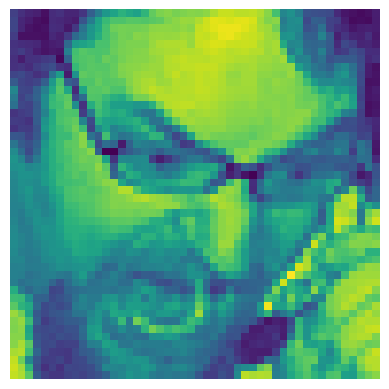

In [44]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image file
image_path = '/kaggle/input/fer2013/test/angry/PrivateTest_10131363.jpg'  # Replace with the actual path to your image file
img = mpimg.imread(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()

In [45]:
pipe("/kaggle/input/fer2013/test/angry/PrivateTest_10131363.jpg")


[{'label': 'angry', 'score': 0.30888602137565613},
 {'label': 'fear', 'score': 0.2893063426017761},
 {'label': 'surprise', 'score': 0.18169903755187988},
 {'label': 'happy', 'score': 0.0918068215250969},
 {'label': 'sad', 'score': 0.05913547798991203}]

Accuracy: 0.5624
F1 Score: 0.4458


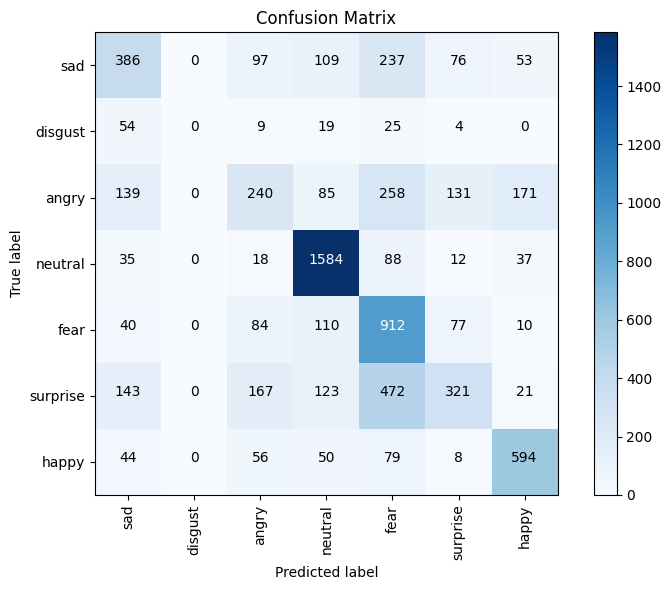


Classification report:

              precision    recall  f1-score   support

         sad     0.4590    0.4029    0.4291       958
     disgust     0.0000    0.0000    0.0000       111
       angry     0.3577    0.2344    0.2832      1024
     neutral     0.7615    0.8929    0.8220      1774
        fear     0.4404    0.7397    0.5521      1233
    surprise     0.5103    0.2574    0.3422      1247
       happy     0.6704    0.7148    0.6919       831

    accuracy                         0.5624      7178
   macro avg     0.4570    0.4632    0.4458      7178
weighted avg     0.5424    0.5624    0.5352      7178



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
labels_list = ['sad', 'disgust', 'angry', 'neutral', 'fear', 'surprise', 'happy'] # list(set(labels))
# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)
    
    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a small number of labels
if len(labels_list) <= 150:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))
    
# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

In [48]:
import torch
from transformers import ViTForImageClassification, AutoFeatureExtractor

# Save the model
torch.save(model.state_dict(), "vit_emotion_model.pth")

# Save the feature extractor
feature_extractor.save_pretrained("vit_feature_extractor")

['vit_feature_extractor/preprocessor_config.json']

In [51]:
import shutil
import os

# Define the source and destination paths
source_dir = "/kaggle/working/"
output_filename = "vit_emotion_model"

# Create a temporary directory to store files we want to zip
temp_dir = "/kaggle/working/temp_for_zip"
os.makedirs(temp_dir, exist_ok=True)

# Copy the files we want to zip into the temporary directory
shutil.copy2(os.path.join(source_dir, "vit_emotion_model.pth"), temp_dir)
shutil.copytree(os.path.join(source_dir, "vit_feature_extractor"), os.path.join(temp_dir, "vit_feature_extractor"))

# Create the zip file
shutil.make_archive(os.path.join(source_dir, output_filename), 'zip', temp_dir)

# Clean up the temporary directory
shutil.rmtree(temp_dir)

print(f"Zip file created: {output_filename}.zip")

Zip file created: vit_emotion_model.zip
